In [194]:
import numpy as np
import numpy.polynomial as P
import scipy as sp
from matplotlib import pyplot as plt
from tqdm import tqdm
#from sklearn.preprocessing import PolynomialFeatures
from multiprocessing import Pool
import multiprocessing
import ZVnbrosse
from sklearn.preprocessing import PolynomialFeatures
from potentials import GaussPotential,GaussMixture,GausMixtureIdent,GausMixtureSame,BananaShape
from samplers import MCMC_sampler,Generate_train,ULA_light
from baselines import set_function,construct_ESVM_kernel,GenerateSigma
from martingale import approx_q
from optimize import Run_eval_test,optimize_parallel_new 
from utils import * 
import copy

In [195]:
def H(k, x):
    if k==0:
        return 1.0
    if k ==1:
        return x
    if k==2:
        return (x**2 - 1)/np.sqrt(2)
    c = np.zeros(k+1,dtype = float)
    c[k] = 1.0
    h = P.hermite_e.hermeval(x,c) / np.sqrt(sp.special.factorial(k)) 
    return h

def compute_H(k,x):
    return H(k[0],x[:,0])*H(k[1],x[:,1])

In [196]:
def test_traj(coefs_poly_regr,gamma,r_seed,lag,K_max,S_max,N_test,x0):
    """
    function to perform 1-dimensional martingale decomposition
    """
    X_test,Noise = generate_traj(x0,N_test,gamma,r_seed)
    S_test = X_test[0,:]
    V_test = X_test[1,:]
    test_stat_vanilla = np.zeros(N_test,dtype = float)
    test_stat_vr = np.zeros_like(test_stat_vanilla)
    #compute number of basis polynomials
    num_basis_funcs = K_max+1
    #compute polynomials of noise variables Z_l
    poly_vals = np.zeros((num_basis_funcs,N_test), dtype = float)
    for k in range(len(poly_vals)):
        poly_vals[k,:] = H(k,Noise[:,0])
    #initialize function
    f_vals_vanilla = X_test[:,0]
    #array to store control variates values
    cvfs = np.zeros_like(f_vals_vanilla)
    #compute coeffitients bar_a
    bar_a_1 = np.zeros((lag,N_test),dtype=float)
    bar_a_2 = np.zeros_like(bar_a_1)
    print(X_test.shape)
    for i in range(lag):
        #second-order coefficients
        bar_a_2[i,1:] = coefs_poly_regr[i,2]*np.sqrt(2)*gamma*(sigma(X_test[:-1]))**2
        bar_a_2[i,0] = coefs_poly_regr[i,2]*np.sqrt(2)*gamma*(sigma(x0))**2
        #first-order coefficients
        bar_a_1[i,1:] = coefs_poly_regr[i,1]*np.sqrt(gamma)*sigma(X_test[:-1]) +\
                coefs_poly_regr[i,2]*2*np.sqrt(gamma)*sigma(X_test[:-1])*(S_test[:-1]+gamma*b(S_test[:-1]))
        bar_a_1[i,0] = coefs_poly_regr[i,1]*np.sqrt(gamma)*sigma(x0) +\
                        coefs_poly_regr[i,2]*2*np.sqrt(gamma)*sigma(x0)*(x0[0]+gamma*b(x0[0]))
    bar_a_1 = bar_a_1*poly_vals[1,:]
    bar_a_2 = bar_a_2*poly_vals[2,:]
    #compute martingale sums
    M_n_1 = 0.0
    M_n_2 = 0.0
    for l in range(N_test):
        for r in range(min(N_test-l,lag)):
            M_n_1 += bar_a_1[r,l]
            M_n_2 += bar_a_2[r,l]
    print("M_n_2: ",M_n_2)
    print("M_n_1: ",M_n_1)
    return np.mean(f_vals_vanilla),np.mean(f_vals_vanilla)-M_n_1/N_test,np.mean(f_vals_vanilla)-M_n_1/N_test-M_n_2/N_test
#
#
#

In [197]:
def approx_q(X_train,Y_train,N_traj_train,lag,max_deg):
    """
    Function to regress q functions on a polynomial basis;
    Args:
        X_train - train tralectory;
        Y_train - function values;
        N_traj_train - number of training trajectories;
        lag - truncation point for coefficients, those for |p-l| > lag are set to 0;
        max_deg - maximum degree of polynomial in regression
    """
    dim = X_train[0,:].shape[0]
    #print("dimension = ",dim)
    coefs_poly = np.array([])
    for i in range(lag):
        x_all = np.array([])
        y_all = np.array([])
        for j in range(N_traj_train):
            y = Y_train[j,i:,0]
            if i == 0:
                x = X_train[j,:]
            else:
                x = X_train[j,:-i]
            #concatenate results
            if x_all.size == 0:
                x_all = x
            else:
                x_all = np.concatenate((x_all,x),axis = 0)
            y_all = np.concatenate([y_all,y])
        #should use polyfeatures here
        #print("variance: ",np.var(y_all))
        #print(y_all[:50])
        poly = PolynomialFeatures(max_deg)
        X_features = poly.fit_transform(x_all)
        #print(X_features.shape)
        lstsq_results = np.linalg.lstsq(X_features,y_all,rcond = None)
        coefs = copy.deepcopy(lstsq_results[0])
        coefs.resize((1,X_features.shape[1]))           
        if coefs_poly.size == 0:
            coefs_poly = copy.deepcopy(coefs)
        else:
            coefs_poly = np.concatenate((coefs_poly,coefs),axis=0)
    return coefs_poly

In [198]:
kappa = 1.2
theta = 0.04
#correlation coefficient in Heston model
rho = 0.5
#interest rate
r = 0.05

def b(S_t):
    """
    b function in the diffusion
    """
    return gamma*r*S_t

def sigma(X_t):
    """
    b function in the diffusion
    """
    if len(X_t.shape) == 1:
        return np.sqrt(X_t[1])*X_t[0]
    else:
        return np.sqrt(X_t[:,1])*X_t[:,0]

def sample_discretized_diffusion(S_t,V_t,gamma_t):
    """
    args:   S_t - asset price;
            V_t - volatility value;
            gamma_t - step size;
            d - dimension;
    returns:  (X_{t+1},xi_{t+1}) - value at the next time moment and the corresponding noise variable
    """
    xi = np.random.randn(2)
    S = (1+r*gamma_t)*S_t + np.sqrt(gamma_t*V_t)*S_t*xi[0]
    V = np.abs(V_t + gamma_t*kappa*(theta-V_t) + np.sqrt(gamma_t*V_t)*(rho*xi[0] + np.sqrt(1-rho**2)*xi[1]))
    return np.array([S,V]),np.array([xi[0],rho*xi[0] + np.sqrt(1-rho**2)*xi[1]])

#currently we use this function without the burn-in
def generate_traj(x0,n,gamma,r_seed):
    """
    args:
        x0 - starting point;
        n - number of steps;
        gamma - step size (assumed to be fixed for now);
    returns:
        x_all,noise_all - np.arrays of shape (n,)  
    """
    x_all = np.zeros((n,d),dtype = float)
    noise_all = np.zeros((n,d),dtype = float)
    np.random.seed(r_seed)
    x_all[0],noise_all[0] = sample_discretized_diffusion(x0[0],x0[1],gamma)
    for i in range(1,n):
        x_all[i],noise_all[i] = sample_discretized_diffusion(x_all[i-1][0],x_all[i-1][1],gamma)
    return x_all,noise_all

def run_monte_carlo(x,f_type):
    if f_type == "quadratic":
        f_vals = x**2
    else:
        raise "not implemented error"
    return np.mean(f_vals,axis=1)

In [199]:
n = 5*10**3 #sample size
gamma = 2e-3 # Step size
n_traj = 1
d = 2
n_traj_test = 100 # Number of independent MCMC trajectories for test
f_type = "linear"
K_max = 2 #max degree of Hermite polynomial
S_max = 2 #max degree of polynomial during regression stage
lag = 50 #maximal lag order
N_test = 5*10**3

Sample discretized diffusion

In [208]:
x0 = np.array([100.0,0.04],dtype = float)
r_seed = 1812
X_train, noise_train = generate_traj(x0,n,gamma,r_seed)
print(X_train[:,1])
#set target function
Y_train = X_train[:,0]
X_train = X_train[:,0].reshape((1,-1,1))
Y_train = Y_train.reshape((1,-1,1))

[0.0361122  0.04201023 0.03058413 ... 0.03270639 0.03933375 0.03525233]


[[100.27913437]]


### Bernoulli:: Optimize coefficients by solving regression with polynomial features

In [201]:
#polynomial coefficients
coefs_poly = approx_q(X_train,Y_train,n_traj,lag,S_max)
print(coefs_poly.shape)
print(coefs_poly)
regr_vals = np.zeros((lag,X_train.shape[1]),dtype=float)
for i in range(len(regr_vals)):
    for j in range(S_max+1):
        regr_vals[i,:] += coefs_poly[i,j]*X_train[0,:,0]**j

(50, 3)
[[-4.17202113e-12  1.00000000e+00  0.00000000e+00]
 [-6.66049877e-01  1.01633821e+00 -9.69834404e-05]
 [-1.29477465e+00  1.03192871e+00 -1.90426083e-04]
 [-1.90696082e+00  1.04712794e+00 -2.81632329e-04]
 [-2.62160222e+00  1.06468013e+00 -3.85899526e-04]
 [-3.07662653e+00  1.07620615e+00 -4.56369642e-04]
 [-3.72592181e+00  1.09205661e+00 -5.50131260e-04]
 [-4.38825252e+00  1.10821838e+00 -6.45666031e-04]
 [-5.07925634e+00  1.12502005e+00 -7.44647677e-04]
 [-5.64261838e+00  1.13886269e+00 -8.27046939e-04]
 [-6.01111933e+00  1.14824448e+00 -8.84793231e-04]
 [-6.39593888e+00  1.15813940e+00 -9.46150816e-04]
 [-6.77585975e+00  1.16792793e+00 -1.00695426e-03]
 [-7.02335300e+00  1.17461039e+00 -1.05015374e-03]
 [-7.13870292e+00  1.17831608e+00 -1.07714436e-03]
 [-7.29113165e+00  1.18281968e+00 -1.10828040e-03]
 [-7.35973401e+00  1.18535485e+00 -1.12823611e-03]
 [-7.35512364e+00  1.18612603e+00 -1.13795015e-03]
 [-7.43175973e+00  1.18885646e+00 -1.15904501e-03]
 [-7.44504637e+00  1.19

Test our regressors

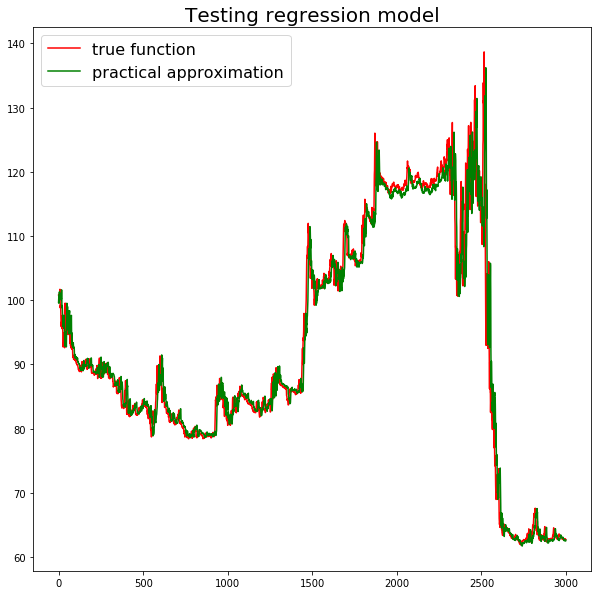

In [202]:
cur_lag = 10
N_pts = 3000
plt.figure(figsize=(10, 10))
plt.title("Testing regression model",fontsize=20)
plt.plot(Y_train[0,cur_lag:N_pts+cur_lag,0],color='r',label='true function')
plt.plot(regr_vals[cur_lag,:N_pts],color='g',label = 'practical approximation')
plt.legend(loc = 'upper left',fontsize = 16)
plt.show()

In [203]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res = trav.starmap(test_traj, [(coefs_poly,gamma,test_seed+i,lag,K_max,S_max,N_test,x0) for i in range (n_traj_test)])
#res = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
trav.close()

(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
M_n_2:  204.3531362333235
M_n_1:  -1412.3066618196494
M_n_2:  -25.29522191341674
M_n_1:  659.2370027073391
M_n_2:  -45.200530486047654
M_n_1:  -4180.641327095692
M_n_2:  36.46796771024463
M_n_1:  1241.2849076258694
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
M_n_2:  -2.7806842251343666
M_n_1:  1092.5177363394064
M_n_2:  86.50442000386008
M_n_1:  -2193.6566543884687
M_n_2:  57.8770106229941
M_n_2:  8.968777412544172
M_n_1:  -1084.1768373039863
M_n_1:  -5907.978706318087
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
M_n_2:  -18.1384181079017
M_n_1:  1045.2589595154845
M_n_2:  153.42962350586217
M_n_1:  -1306.3550638031936
M_n_2:  23.588943436194917
M_n_2:  -8.078459255543448
M_n_1:  -3513.0033549043583
M_n_1:  -1495.6570522475122
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
M_n_2:  0.035606894136180685
M_n_1:  -4842.202834461872
M_n_2:  -119.20471682041675
M_n_1:  4435.478481616513
M_n_2:  -25.515904568484924
M_n_2:  2923.5529878265793
M_n_1:  10881.202718323993


In [204]:
res_new = np.asarray(res)
print(res_new.shape)

(100, 3)


### Comparison plots

In [205]:
title = ""
labels = ['Vanilla\n Euler scheme', 'Euler scheme \nwith MDCV-1']
#labels = ['Vanilla\n ULA', 'ULA \nwith MDCV-1', 'ULA \nwith MDCV-2']

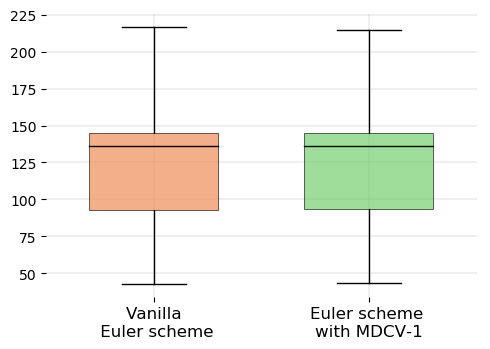

In [206]:
data = [res_new[:,0],res_new[:,1]]#,res_new[:,2]] 
boxplot_ind(data, title, labels,path="./Heston_price.pdf")